In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# 필요한 라이브러리들 불러오기
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import Input
import numpy as np
import pickle
import pandas as pd
import random
from tqdm import tqdm
from time import sleep

tf.random.set_seed(7)

In [3]:
x_sequence_train_tf = np.load('../x_sequence_train_noise_ver3.npy')
x_sequence_test_tf = np.load('../x_sequence_test_noise_ver3.npy')

print(x_sequence_train_tf.shape)
print(x_sequence_test_tf.shape)

(60000, 472)
(10000, 472)


In [4]:
# 정답지 생성
train_label_textfile = pd.read_csv('../trainlabels.txt',index_col=False)
train_label = np.array(train_label_textfile)

test_label_textfile = pd.read_csv('../testlabels.txt',index_col=False)
test_label = np.array(test_label_textfile)

y_train = tf.keras.utils.to_categorical(train_label, num_classes=10)
y_test = tf.keras.utils.to_categorical(test_label, num_classes=10)

In [5]:
# 그래프 그려주는 함수
from matplotlib import pyplot as plt

def graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(acc)+1)
    
    plt.plot(epochs, acc, 'r',label = 'Training acc')
    plt.plot(epochs, val_acc, 'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    
    plt.legend(loc='lower right')
    plt.show()

## 2.1 LSTM 128

In [6]:
sequence_input_lstm = Input(shape = (118*4), dtype = 'int32', name = 'sequence_mnist_lstm')
y = layers.Embedding(512,128, mask_zero = True)(sequence_input_lstm)
y = layers.LSTM(128)(y)
# 32 대신에 다른 숫자도 넣어보도록 함.

sequence_output = layers.Dropout(0.5)(y)
answer = layers.Dense(10, activation = 'softmax')(sequence_output)

2022-05-04 21:25:39.742588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 21:25:40.114787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22360 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6


In [7]:
model_2_1 = Model([sequence_input_lstm], answer)
model_2_1.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [8]:
model_2_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_mnist_lstm (InputLa [(None, 472)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 472, 128)          65536     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 198,410
Trainable params: 198,410
Non-trainable params: 0
_________________________________________________________________


In [9]:
history2_1 = model_2_1.fit([x_sequence_train_tf], y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

2022-05-04 21:25:41.023516: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-04 21:25:43.348443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


375/375 [==============================] - 134s 351ms/step - loss: 1.6899 - acc: 0.3869 - val_loss: 1.5143 - val_acc: 0.4672
Epoch 2/100
375/375 [==============================] - 131s 349ms/step - loss: 1.3430 - acc: 0.5355 - val_loss: 1.1887 - val_acc: 0.5953
Epoch 3/100
375/375 [==============================] - 131s 350ms/step - loss: 1.2055 - acc: 0.5961 - val_loss: 1.0683 - val_acc: 0.6355
Epoch 4/100
375/375 [==============================] - 131s 349ms/step - loss: 1.0978 - acc: 0.6358 - val_loss: 0.9993 - val_acc: 0.6599
Epoch 5/100
375/375 [==============================] - 130s 348ms/step - loss: 1.0273 - acc: 0.6621 - val_loss: 0.9716 - val_acc: 0.6731
Epoch 6/100
375/375 [==============================] - 131s 348ms/step - loss: 0.9797 - acc: 0.6796 - val_loss: 0.9311 - val_acc: 0.6892
Epoch 7/100
375/375 [==============================] - 131s 349ms/step - loss: 0.9452 - acc: 0.6905 - val_loss: 0.8899 - val_acc: 0.6996
Epoch 8/100
375/375 [==============================] 

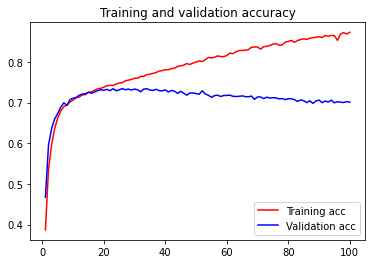

In [10]:
graph(history2_1)

In [11]:
model_2_1_eval = model_2_1.evaluate([x_sequence_test_tf], y_test, verbose=2)
model_2_1_eval

313/313 - 21s - loss: 1.1683 - acc: 0.7050


[1.1682963371276855, 0.7049999833106995]

## 2. BiLSTM

In [12]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = layers.Dense(units)
    self.W2 = layers.Dense(units)
    self.V = layers.Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [13]:
sequence_input_lstm = Input(shape = (118*4), dtype = 'int32', name = 'sequence_mnist_lstm')
y = layers.Embedding(512,32)(sequence_input_lstm)
lstm = layers.Bidirectional(layers.LSTM(32, dropout=0.5, return_sequences = True))(y)
lstm, forward_h, forward_c, backward_h, backward_c = layers.Bidirectional(layers.LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

# 1. Dense
# 2. BN
# 3. Activation


# BN
BN = layers.BatchNormalization()(context_vector)
dense1 = layers.Dense(20, activation="relu")(BN)

dropout = layers.Dropout(0.5)(dense1)

answer = layers.Dense(10, activation = 'softmax')(dropout)

In [14]:
model_2_2 = Model([sequence_input_lstm], answer)
model_2_2.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [15]:
model_2_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_mnist_lstm (InputLayer [(None, 472)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 472, 32)      16384       sequence_mnist_lstm[0][0]        
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 472, 64)      16640       embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 472, 128), ( 66048       bidirectional[0][0]              
____________________________________________________________________________________________

In [16]:
history2_2 = model_2_2.fit([x_sequence_train_tf], y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


2022-05-05 01:06:10.942814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


375/375 [==============================] - 38s 90ms/step - loss: 1.8979 - acc: 0.2977 - val_loss: 2.3136 - val_acc: 0.1767
Epoch 2/100
375/375 [==============================] - 34s 91ms/step - loss: 1.6205 - acc: 0.4016 - val_loss: 2.0101 - val_acc: 0.3385
Epoch 3/100
375/375 [==============================] - 34s 92ms/step - loss: 1.6858 - acc: 0.3870 - val_loss: 1.7960 - val_acc: 0.3507
Epoch 4/100
375/375 [==============================] - 33s 89ms/step - loss: 1.5320 - acc: 0.4487 - val_loss: 1.3712 - val_acc: 0.4979
Epoch 5/100
375/375 [==============================] - 34s 92ms/step - loss: 1.4770 - acc: 0.4740 - val_loss: 1.3117 - val_acc: 0.5498
Epoch 6/100
375/375 [==============================] - 34s 92ms/step - loss: 1.4347 - acc: 0.4928 - val_loss: 1.2116 - val_acc: 0.5975
Epoch 7/100
375/375 [==============================] - 34s 91ms/step - loss: 1.4043 - acc: 0.5043 - val_loss: 1.2184 - val_acc: 0.5606
Epoch 8/100
375/375 [==============================] - 33s 87ms/ste

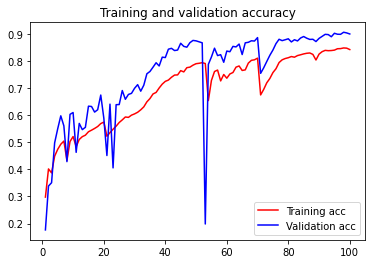

In [17]:
graph(history2_2)

In [18]:
model_2_2_eval = model_2_2.evaluate([x_sequence_test_tf], y_test, verbose=2)
model_2_2_eval

313/313 - 11s - loss: 0.3442 - acc: 0.9036


[0.34421470761299133, 0.9035999774932861]

## 2.3 Transformer

In [19]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [21]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 118*4
vocab_size = 1000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_2_3 = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
model_2_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 472)]             0         
_________________________________________________________________
token_and_position_embedding (None, 472, 32)           47104     
_________________________________________________________________
transformer_block (Transform (None, 472, 32)           10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0   

In [23]:
model_2_3.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

In [24]:
history2_3 = model_2_3.fit([x_sequence_train_tf], y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100
375/375 [==============================] - 7s 18ms/step - loss: 2.2849 - acc: 0.1234 - val_loss: 2.1091 - val_acc: 0.1943
Epoch 2/100
375/375 [==============================] - 7s 17ms/step - loss: 1.9821 - acc: 0.2565 - val_loss: 1.8011 - val_acc: 0.3362
Epoch 3/100
375/375 [==============================] - 7s 17ms/step - loss: 1.4593 - acc: 0.4770 - val_loss: 1.2105 - val_acc: 0.5704
Epoch 4/100
375/375 [==============================] - 7s 17ms/step - loss: 1.1925 - acc: 0.5869 - val_loss: 1.0523 - val_acc: 0.6362
Epoch 5/100
375/375 [==============================] - 7s 17ms/step - loss: 1.0606 - acc: 0.6372 - val_loss: 0.9772 - val_acc: 0.6684
Epoch 6/100
375/375 [==============================] - 7s 17ms/step - loss: 0.9725 - acc: 0.6700 - val_loss: 0.8806 - val_acc: 0.6988
Epoch 7/100
375/375 [==============================] - 7s 17ms/step - loss: 0.9239 - acc: 0.6885 - val_loss: 0.8415 - val_acc: 0.7117
Epoch 8/100
375/375 [==============================] - 6s 17ms

Epoch 62/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4546 - acc: 0.8562 - val_loss: 0.4626 - val_acc: 0.8572
Epoch 63/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4518 - acc: 0.8590 - val_loss: 0.4678 - val_acc: 0.8570
Epoch 64/100
375/375 [==============================] - 7s 17ms/step - loss: 0.4465 - acc: 0.8606 - val_loss: 0.4742 - val_acc: 0.8544
Epoch 65/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4465 - acc: 0.8600 - val_loss: 0.4660 - val_acc: 0.8575
Epoch 66/100
375/375 [==============================] - 7s 17ms/step - loss: 0.4402 - acc: 0.8622 - val_loss: 0.4816 - val_acc: 0.8534
Epoch 67/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4411 - acc: 0.8613 - val_loss: 0.4562 - val_acc: 0.8593
Epoch 68/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4400 - acc: 0.8608 - val_loss: 0.4636 - val_acc: 0.8600
Epoch 69/100
375/375 [==============================] -

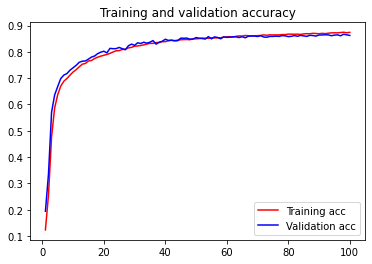

In [25]:
graph(history2_3)

In [26]:
model_2_3_eval = model_2_3.evaluate([x_sequence_test_tf], y_test, verbose=2)
model_2_3_eval

313/313 - 1s - loss: 0.4202 - acc: 0.8674


[0.4201706051826477, 0.8673999905586243]